# Gavin Kendal-Freedman

## Research question/interests

**My main interest is how different chemicals effect air quality ratings, specifically the main hazardous components in fuels for motor vehicles or stoves like natural gas/gasoline/diesel fuels (benzene, toluene, propane, methane, sulfurs/oxides of nitrogens, 2,2,4-Trimethylpentane (octane from standard gasoline)), and also potentially common organic solvents/reagents that are used in manufacturing (methacrylates, chloroform/methyl chloroform, acetylene, nitric acid), and how these different particulates effect AQI. Further, I want to see if there is a significant difference in air quality change across time in urban vs rural areas (not just if urban areas have better/worse air quality), based on specific particulates in the first part, and if there is any correlations between asthma rates in different areas and the levels of pollutants there (not across time because the asthma data does not have a time series attached to it).**

### Rough Plan for Data Analysis

1. (Already done as part of loading) Combine all EPA data files into one dataframe
1. Remove all rows that do not contain the parameters of interest (see above)
1. Remove columns that are mostly null/na/nan/missing values or are not interesting to the analysis
1. For locations that have multiple observations for a parameter in a year, average them and all statistics about the measurements for the year
1. Isolate a single metric for each parameter of interest (preferably "Observed Values"), preferably an overall average for the year and not the mean for daily maximums
1. Check for any correlations between the parameters of interest to other parameters of interest, and the AQI
1. Check changes in concentrations over time and see if there are any correlations between the changes in concentrations and the AQI
1. Geo-plot the change in AQI over time for each location, with an overlay showing the change in a normalization and aggregation of the parameters of interest
1. For 2020, geo-plot the AQI and the parameters of interest for each location and overlay the asthma rates for each location

---

### Rough Draft of Final analysis/Summary of Analysis:

Looking at the US as a whole, from the [heatmap](../images/gavin-heatmap.png), the Air Quality is most directly died to Ozone, Carbon Monoxide, and Nitro (NO<sub>x</sub>) compounds, with a lower dependence on Sulfur Dioxide, a common output from burning certain fuels like diesel and some natural gasses.

Looking at the [plot](../images/gavin-plot-1.png) of Max AQI against Crude Asthma prevalence, there is a relation that can be seen in certain areas between asthma and AQI, in Washington, Oregon, Arizona, and New Mexico. However, looking on the eastern portion of the US, AQI is much lower, but on the states west of the eastern coast states, a band of relatively higher asthma prevalence can be seen, indicating that AQI is a bad predictive index for asthma on it own. Further, AQI tends to be higher on the west coast, due to the more frequent and large wildfire events<sup>[1]</sup> on the west coast, especially in 2020<sup>[2]</sup>, causing sampling bias in the AQI data. Furthermore, it was noticed that certain places reported AQI of over 500, the maximum value of the US scale, and as such, those values were set to `501`, to differentiate them from values of `500`.

Comparing the different aggregated parameters on the [heatmap](../images/gavin-heatmap.png) for 2020 comes the next analysis and [plot](../images/gavin-plot-2.png), Which shows using medium AQI a more representative idea of the parameters the affect asthma and air quality. Comparing asthma data to median AQI shows a stronger corelation, but not enough to be able to judge direct corelation between AQI and asthma prevalence. However, the correlations between AQI and the aggregated parameters seen in the heatmap can be confirmed from this plot, especially in industrial regions like the midwestern, eastern, and southwestern regions of the US. Overall the northwestern US seems to follow the same trends to a lesser extent, sometimes deviating from the trends, especially in urban areas, and certain areas of the US have little to no data, like the northern region of the central US. Analyzing the parameters against asthma shows few correlations, but the ones that exist are fairly strong, with Ozone, Nitrous compounds, and carbon monoxide, all showing fairly strong positive correlations, especially in the corn and tornado belts/alleys of the US.

Finally, the last [geographic plot](../images/gavin-plot-3.png) and the [violin plot](../images/gavin-aqi-violinplot.png) show median AQI across time as deltas and absolutes, which shows that over time, there are fluctuations across the country across years, there are small, temporary fluctuations, but overall AQI tends to have stayed fairly steady over time at median<sup>[3]</sup> yearly readings. 

#### Conclusion

In summary, we can find positive correlations between Ozone Levels, Carbon Monoxide, Nitro (NO<sub>x</sub>) Compounds, with a potential weak correlation with Sulfur Dioxide, an emission from some fuels like diesel and natural gas. Futhermore, There is not a direct correlation between AQI and Crude asthma prevalence in the US, however comparing individual groups of parameters shows that there is a correlation between Ozone, Nitro (NO<sub>x</sub>) Compounds, and Carbon Monoxide, at least in certain portions of the US (corn and tornado belts/alleys), which show there is not a difference between rural and urban areas necessarily. A final analysis across times showed that AQI does not vary massively across time, at least over the time period investigated, and the minor variations across years are not significant, especially once differences due to wildfire events<sup>[1]</sup> have been taken into account.


---
##### Footnotes

1. [2020 Western US Wildfire Season](https://en.wikipedia.org/wiki/2020_Western_United_States_wildfire_season) - While Wikipedia is not a primary source, it has aggregated information about the extent of wildfires this year, and more complete information is available on the internet if the reader wishes to go into more detail. The exacts of the wildfires are not important for the data analysis here, just that the AQI is highly sample biased on the west coast for 2020.

2. Given the wildfires and as such sampling bias issues identified, the reader may ask why 2020 was chosen as the year for air quality. The asthma data released by the CDC was only for the year 2020 and as such, the most representative year to compare it to air quality was 2020, other years may have different measurements of other populations which could skew analysis further, and since the main particulates from wildfire smoke (PM2.5, PM10, and CO<sub>2</sub>) are not being analyzed here, the wildfires will not effect the analysis very much overall.

3. Median readings were chosen here over Max AQI to limit the effects of wildfires as discussed above.

---

In [1]:
# Imports
from itertools import chain

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_color
import numpy as np
import seaborn as sns
from pyproj import CRS

import scripts.project_functions1 as utils

In [2]:
# Setup seaborn/geoplot/matplotlib theme/plotting information
sns.set_theme(style="darkgrid", font_scale=1.5)  # type: ignore
projection = gcrs.AlbersEqualArea(central_latitude=39.8282, central_longitude=-98.5795)
crs = CRS.from_user_input("EPSG:4269")
USE_CACHED = True
RELOAD_UTILS = False

In [3]:
# Load the data using the function

# First, check if the project functions files need reloading
if RELOAD_UTILS:
    from importlib import reload

    reload(utils)


# If the first dataset (EPA Air Data) has already been processed, and we aren't expecting changes:
if USE_CACHED and (utils.PROJECT_ROOT / "data/processed/processed1.csv").exists():
    # then load the processed data here
    df = utils.load_preprocessed_1(
        utils.PROJECT_ROOT / "data/processed/geodata1.geojson",
        utils.PROJECT_ROOT / "data/processed/processed1.csv",
    )
else:
    # Otherwise, lets process it from the raw data
    df: gpd.GeoDataFrame = utils.load_and_process(range(2011, 2023))
# If the second dataset (CDC Health Data) has already been processed, and we aren't expecting changes:
if USE_CACHED and (utils.PROJECT_ROOT / "data/processed/heath1.geojson").exists():
    # then load the processed data here
    healthdata = utils.load_preprocessed_2(utils.PROJECT_ROOT / "data/processed/heath1.geojson")
else:
    # Otherwise, lets process it from the raw data
    healthdata = utils.load_and_process_healthdata()
shapedata: gpd.GeoDataFrame = gpd.read_file(utils.PROJECT_ROOT / "data/raw/contiguous-usa.geojson", **utils.GPD_READ_KWARGS)  # type: ignore

In [4]:
df2 = (
    df.pivot_table(
        values=["Arithmetic Mean"],  # pyright: ignore
        columns=["Parameter Name"],
        index=["CBSA Name", "Year"],
    )
    .droplevel(0, axis=1)
    .merge(
        df.drop(columns=["Arithmetic Mean", "Parameter Name"]),
        how="left",
        left_index=True,
        right_on=["CBSA Name", "Year"],
    )
).set_index(["Year", "CBSA Name"])
df2 = gpd.GeoDataFrame(df2, geometry=df2.geometry)  # type: ignore

In [5]:
parameters = [
    "Median AQI",
    "Ozone",
    "Ammonium compounds",
    "Carbon monoxide",
    "Heavy Metals",
    "Nitric oxides",
    "Nitrogen dioxide (NO2)",
    "Sulfur dioxide",
    "Various Particulates",
    "Benzenes",
]

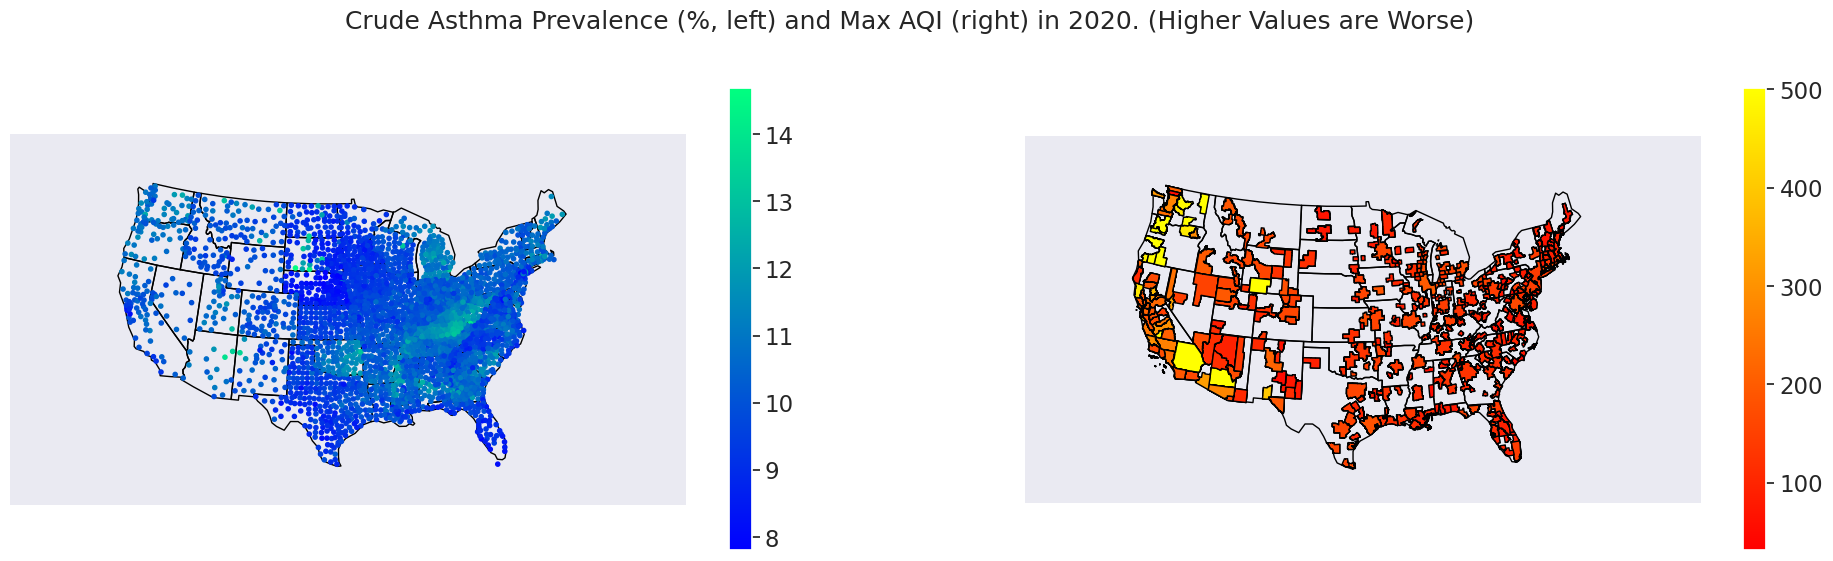

In [6]:
fig, (left, right) = plt.subplots(
    1,
    2,
    figsize=(24, 6),
    subplot_kw={"projection": projection},
    sharex=True,
    sharey=False,
    squeeze=True,
)

gplt.polyplot(shapedata, ax=left)
gplt.polyplot(shapedata, ax=right)
gplt.pointplot(
    healthdata,
    hue="Percentage",
    scale="Percentage",
    legend_var="hue",
    legend=True,
    limits=(3, 3),
    cmap="winter",
    ax=left,
)
gplt.choropleth(
    df2.dropna(subset="Max AQI").loc[2020],
    hue="Max AQI",
    legend=True,
    ax=right,
    edgecolor="black",
    linewidth=1,
    cmap="autumn",
)
fig.suptitle(
    "Crude Asthma Prevalence (%, left) and Max AQI (right) in 2020. (Higher Values are Worse)",
    va="baseline",
    fontsize=18,
)
None

This is the initial graph to compare the main two parameters of interest, asthma prevalence and AQI across locations, and overall it shows there can be a trend observed between AQI and asthma prevalence, but max AQI is not a good representative for AQI in this regard, and while there is a trend, it is not a strong one, and there are many outliers that make it difficult to draw any conclusions from this graph, at least using Max AQI, due to wildfires in [2020 on the west coast](https://en.wikipedia.org/wiki/2020_Western_United_States_wildfire_season). However, max AQI allows us to see the effect of wildfires on west coast air quality that 90th percentile and median doesn't show.

---

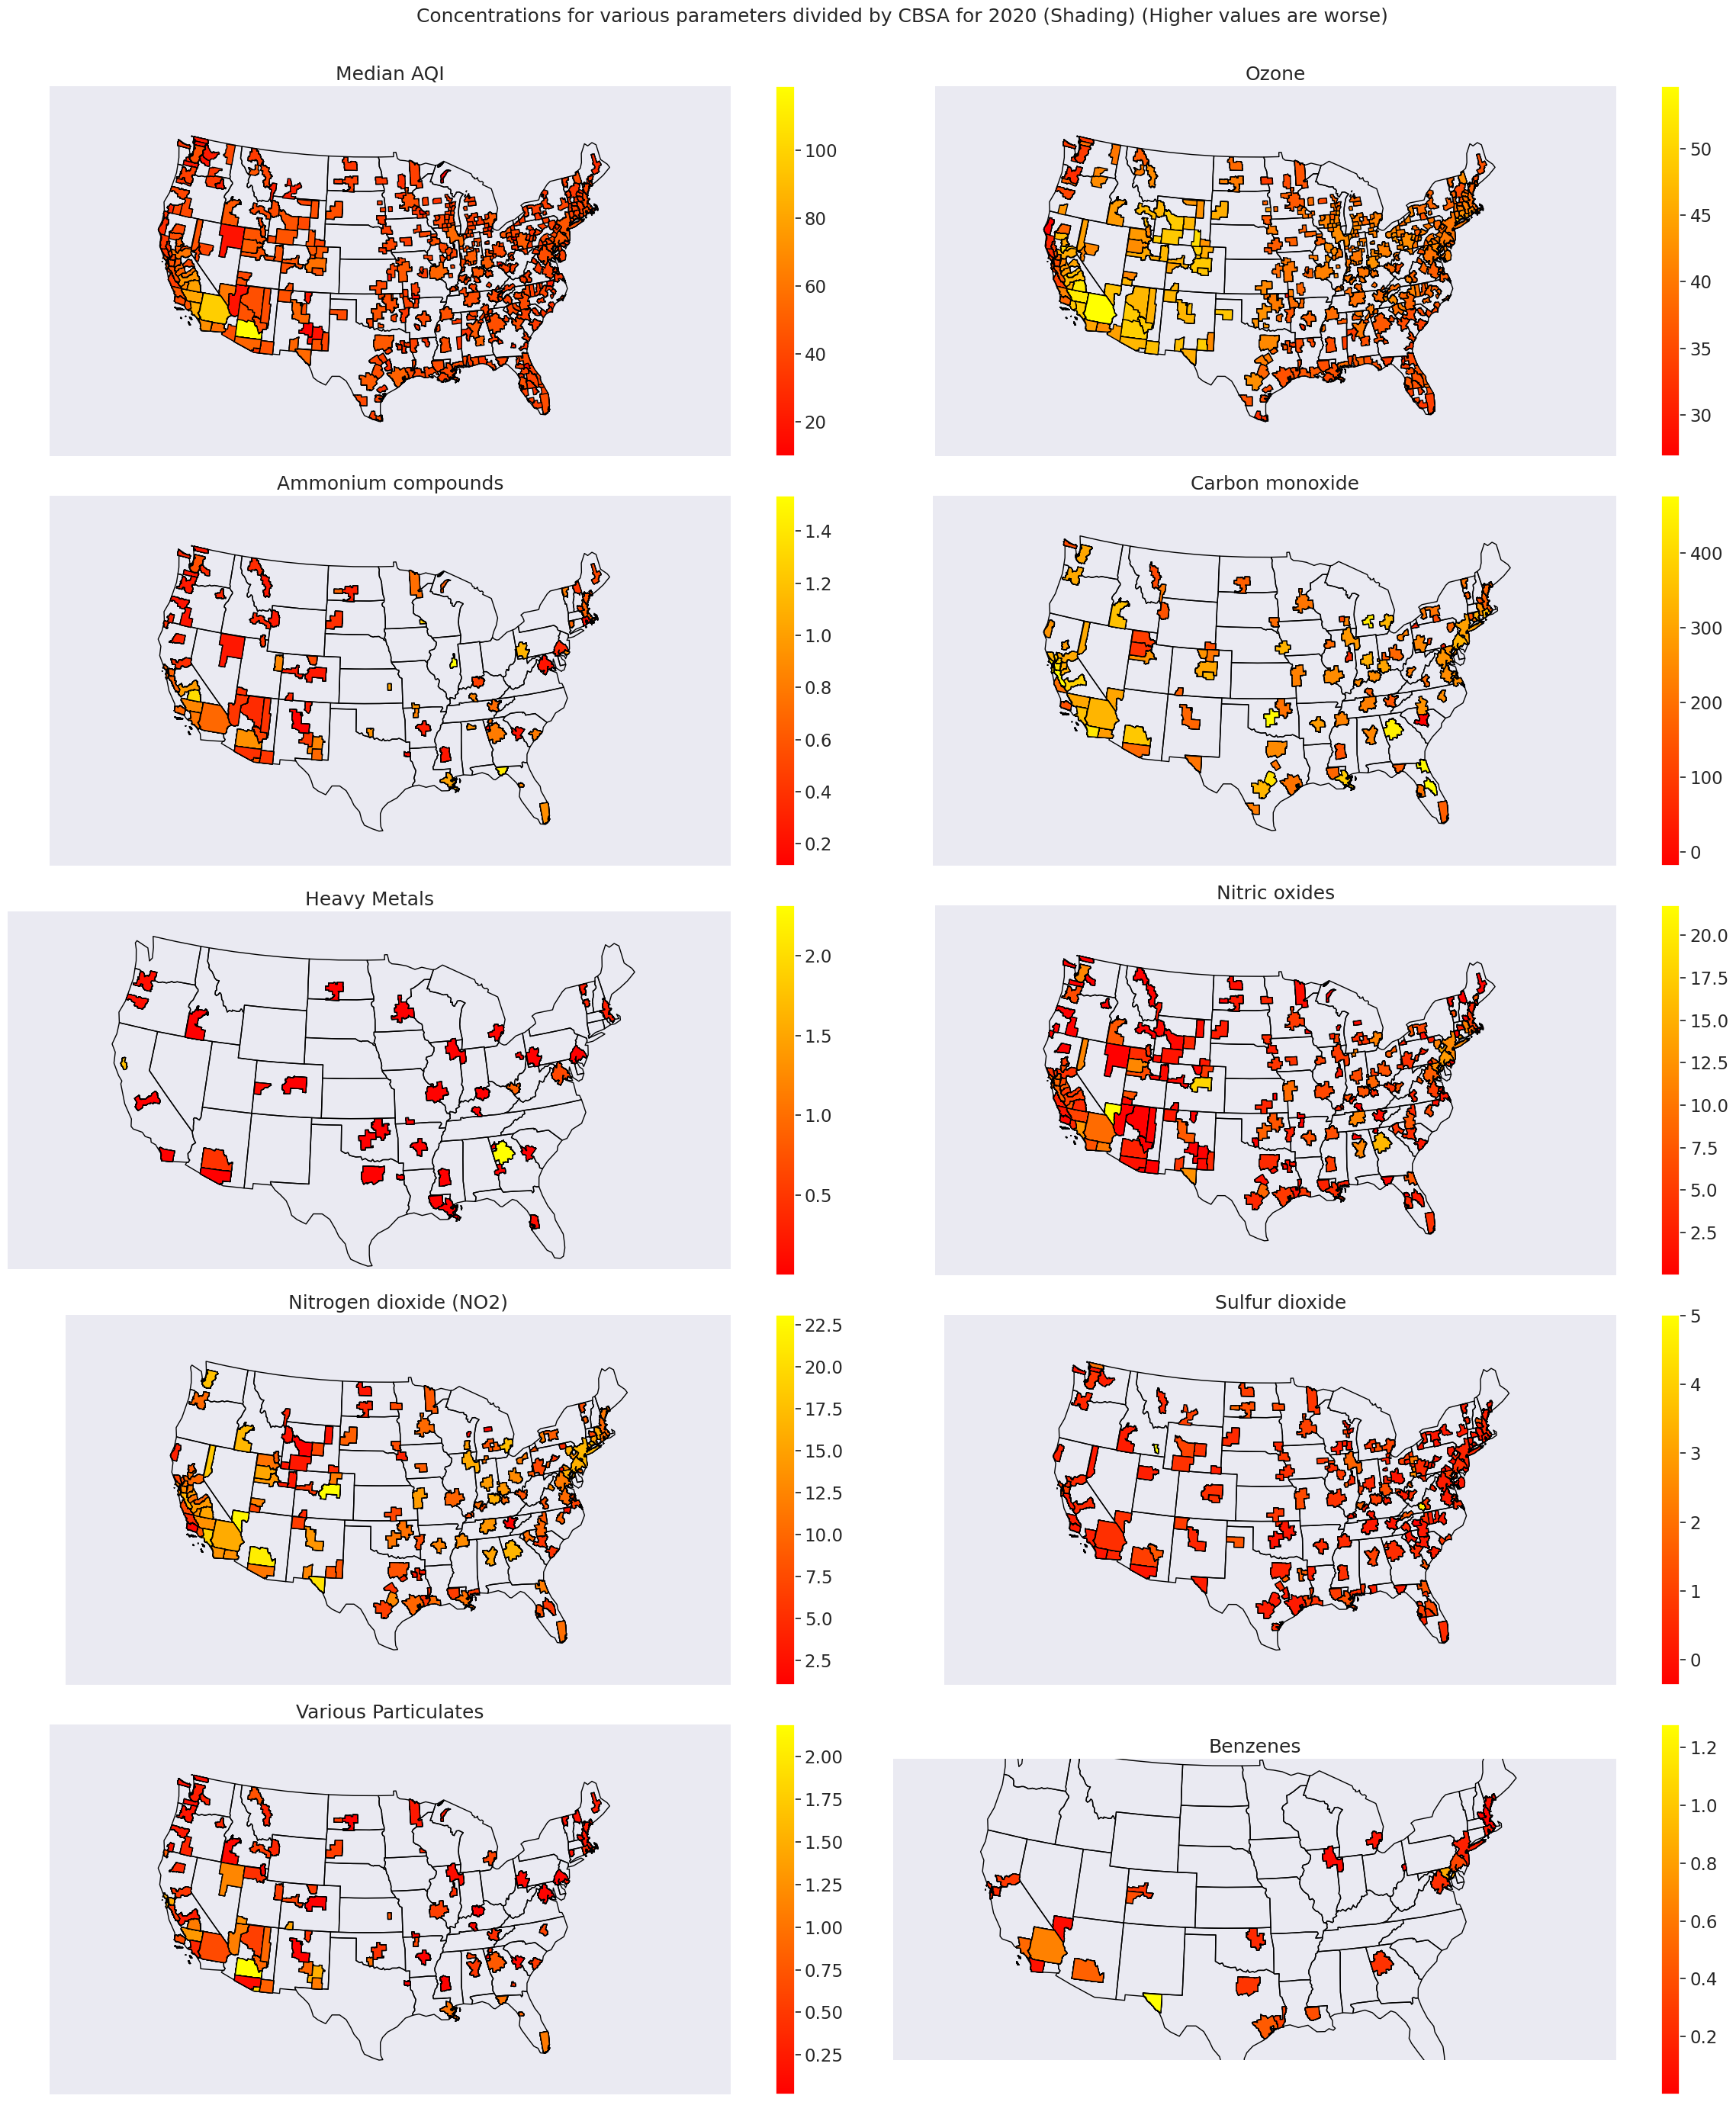

In [7]:
fig, axarr = plt.subplots(
    5,
    2,
    figsize=(24, 28),
    subplot_kw={"projection": projection},
    sharex=False,
    sharey=False,
)
for param, ax in zip(parameters, chain.from_iterable(axarr)):
    gplt.polyplot(shapedata, ax=ax)
    gplt.choropleth(
        df2.dropna(subset=param).loc[2020],
        hue=param,
        legend=True,
        ax=ax,
        edgecolor="black",
        linewidth=1,
        cmap="autumn",
    )
    ax.set_title(label=param, fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle(
    "Concentrations for various parameters divided by CBSA for 2020 (Higher values are worse)",
    va="baseline",
    fontsize=18,
)
None

Here, we can see the primary contributors to AQI are in the categories of Ozone, Ammonium Compounds, Nitrous Compounds/NO2, and Carbon Monoxide, while the parameters that most associate with higher crude asthma prevalence is Ozone, Carbon Monoxide, Nitric Oxides/NO2, and Sulfur Dioxide. Further, there is also a non insignificant relation between asthma and AQI, as well as between the different parameters and asthma which is fairly stable even across geographic locations, showing the trends are caused by commonalities across those location that emit the aggregated parameters of interest.

---

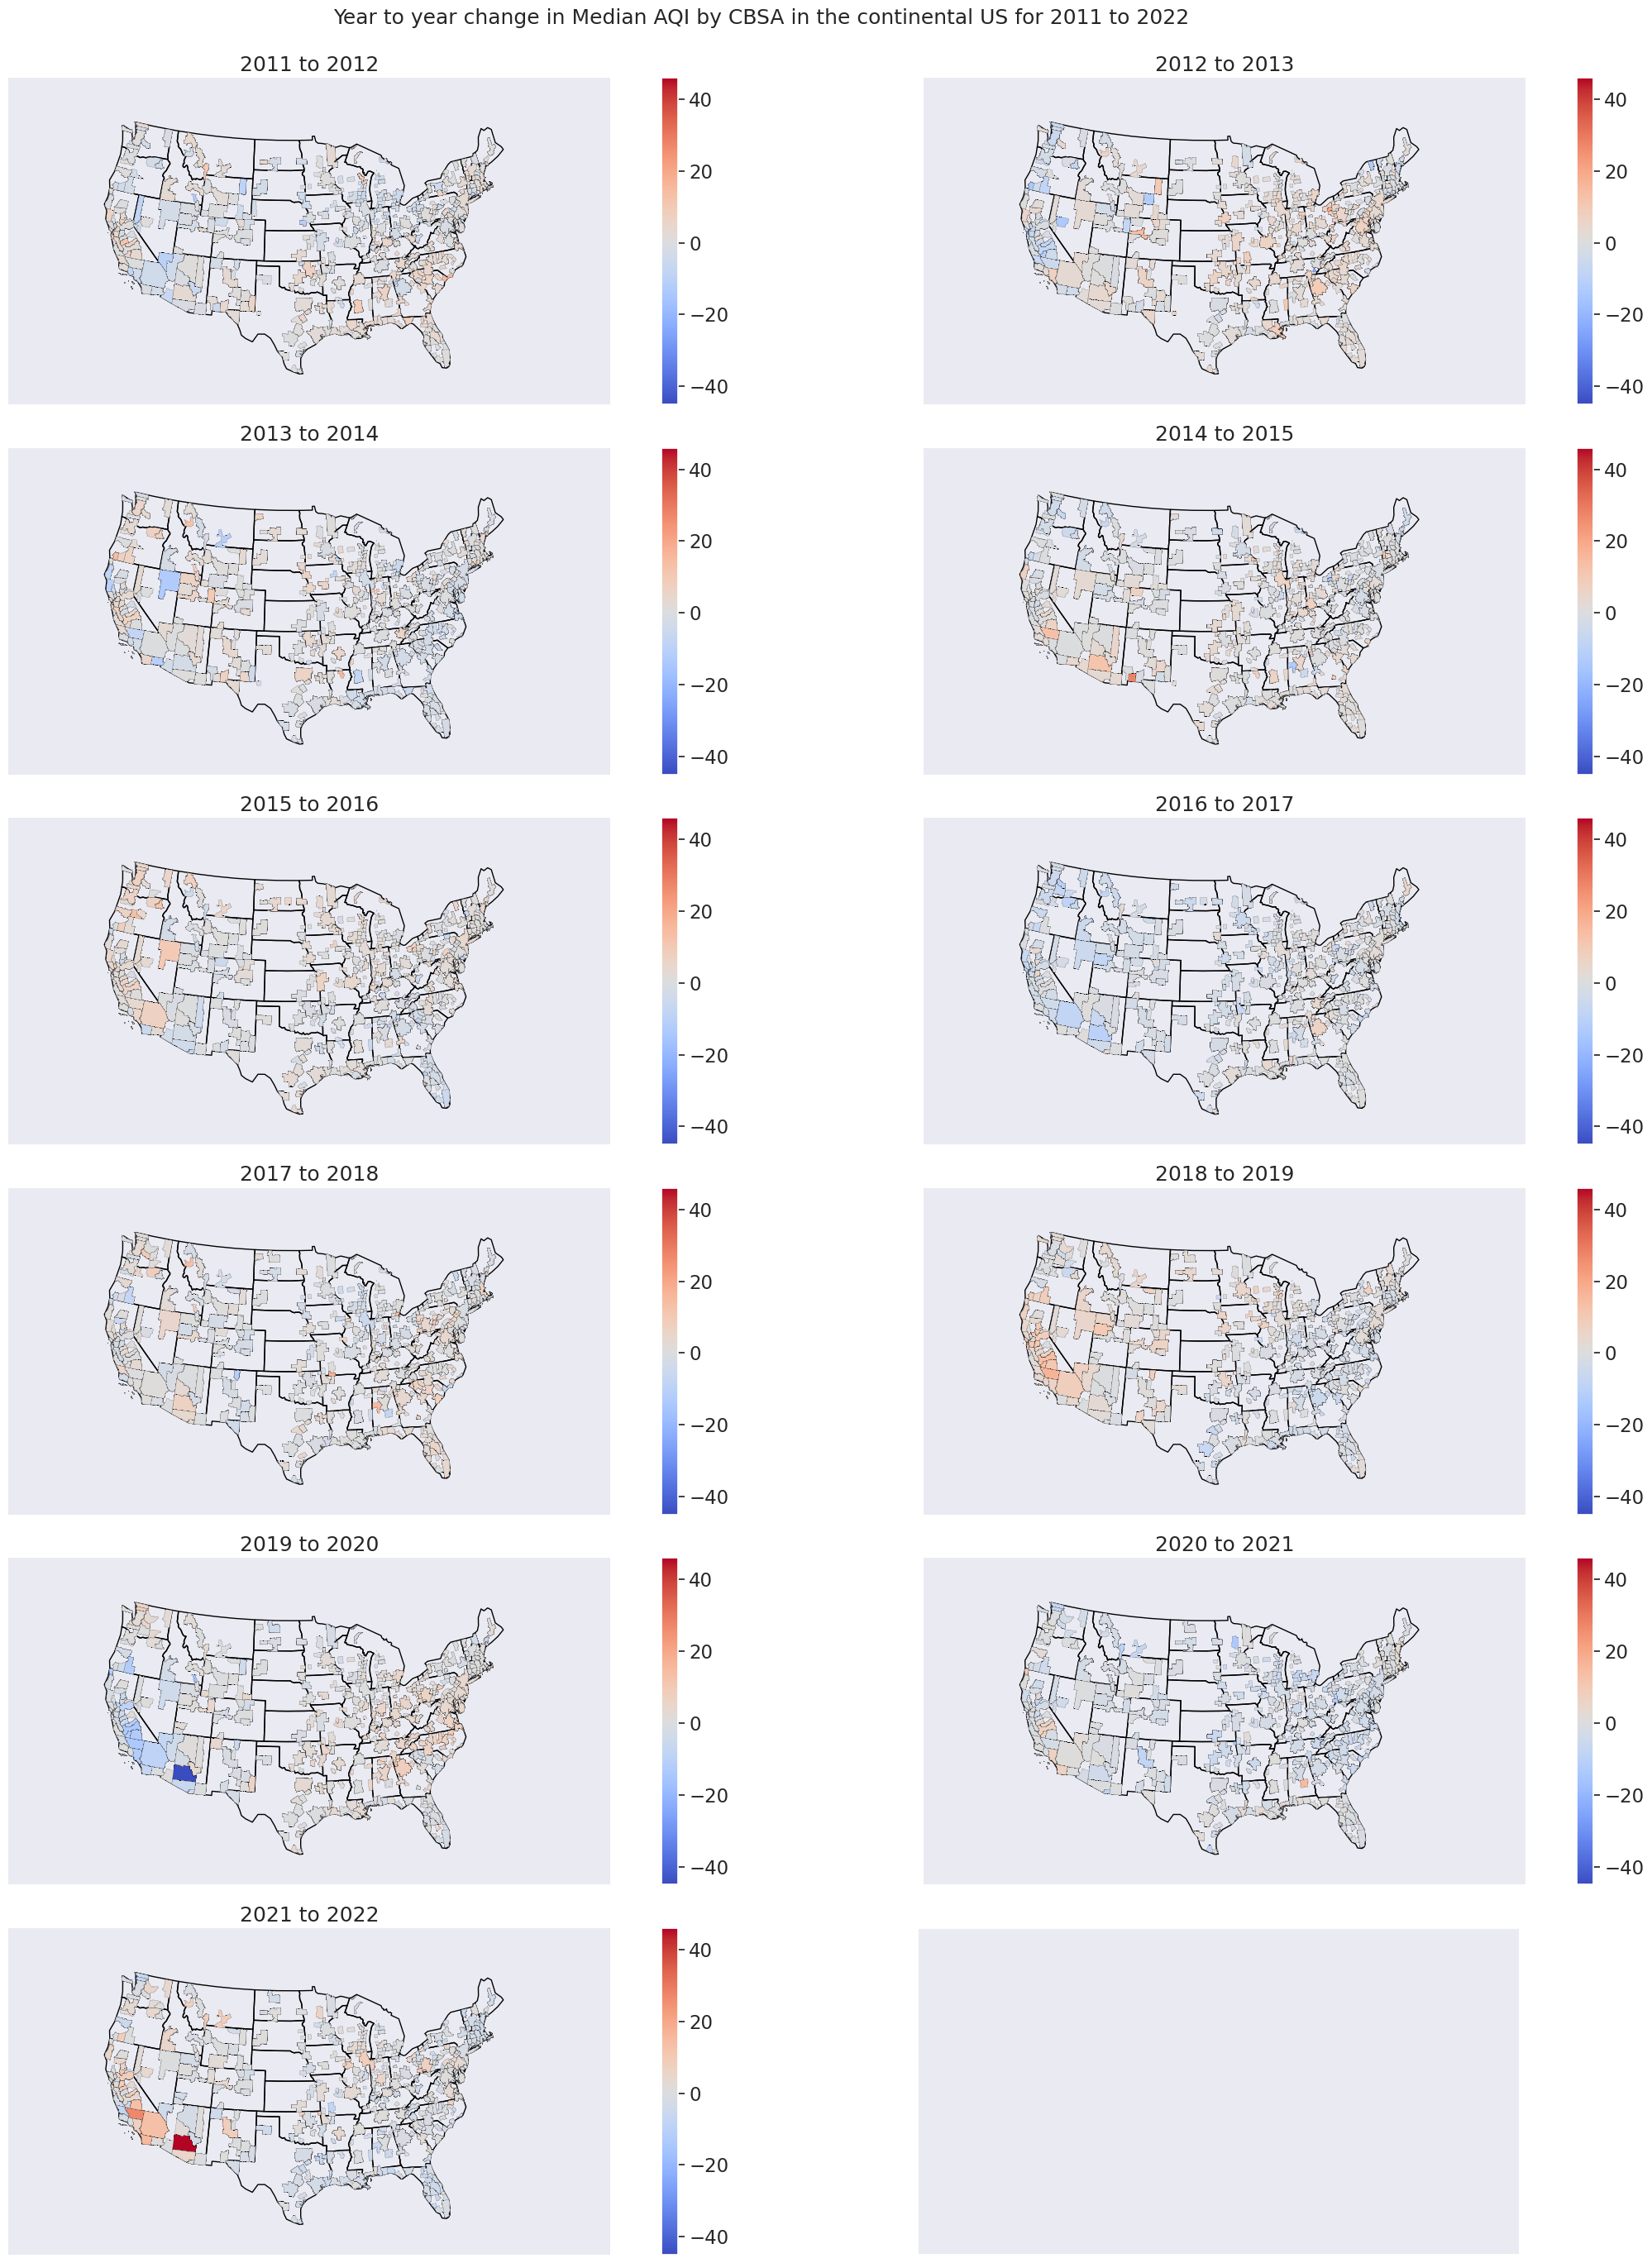

In [8]:
fig2, axarr2 = plt.subplots(
    6,
    2,
    figsize=(24, 28),
    subplot_kw={"projection": projection},
    sharex=True,
    sharey=True,
    squeeze=True,
)
diffs = df2[["geometry", "Latitude", "Longitude"]].merge(
    df2["Median AQI"]
    .groupby(level=1)
    .diff(periods=-1)
    .dropna()
    .reset_index()
    .drop_duplicates()
    .reset_index()
    .set_index(["Year", "CBSA Name"]),
    how="right",
    left_index=True,
    right_index=True,
)
normalizer = mpl_color.Normalize(diffs["Median AQI"].min(), diffs["Median AQI"].max())
for year, ax in zip(range(2011, 2022), chain.from_iterable(axarr2)):
    gplt.polyplot(shapedata, ax=ax)
    gplt.choropleth(
        diffs.loc[year],
        hue="Median AQI",
        ax=ax,
        legend=True,
        edgecolor="black",
        linewidth=0.1,
        cmap="coolwarm",
        norm=normalizer,
    )
    ax.set_title(f"{year} to {year+1}", fontsize=18)
fig2.tight_layout()
fig2.subplots_adjust(top=0.95)
fig2.suptitle("Year to year change in Median AQI by CBSA in the continental US for 2011 to 2022", fontsize=18)
None

The main point of the plot is to show that across time, there are no overall major swings or changes in where higher regions of AQI are, across time, though overall there tends to be a slight trend of oscillating, going up a tad, and then back down. It is worth to note here that certain values in the southwest had maximum AQI values over 500, which is the maximum value of the AQI scale, and as such, those values were set to 501 to differentiate them from the maximum value of 500 when Max AQI was used, without shifting the scale

---

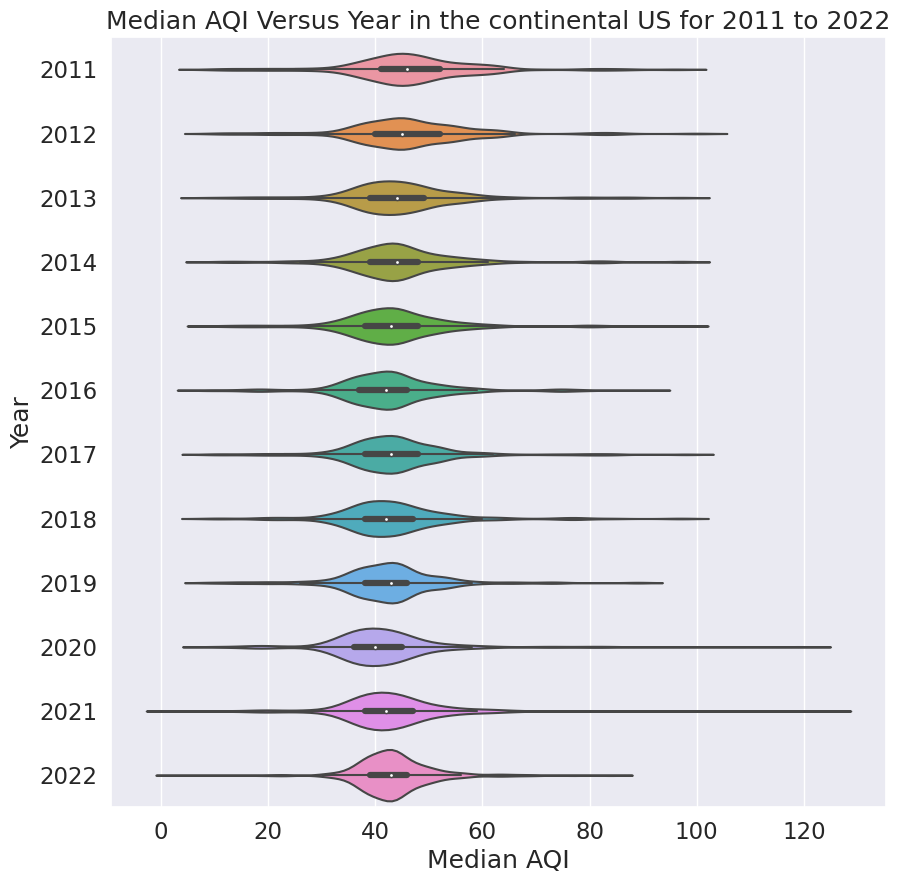

In [9]:
violin_fig, violin_ax = plt.subplots(figsize=(10, 10))
sns.violinplot(df, y="Year", x="Median AQI", orient="h", ax=violin_ax)
violin_ax.set_title("Median AQI Versus Year in the continental US for 2011 to 2022", fontsize=18)
None

This plot reinforces what the above set of choropleths show - across years there is not a major difference in AQI at the median level, but there are small increases and decreases from year to year and overall there does appear to be a slight trend towards the central point of the median AQI creeping upwards, however not enough to show anything major.

---

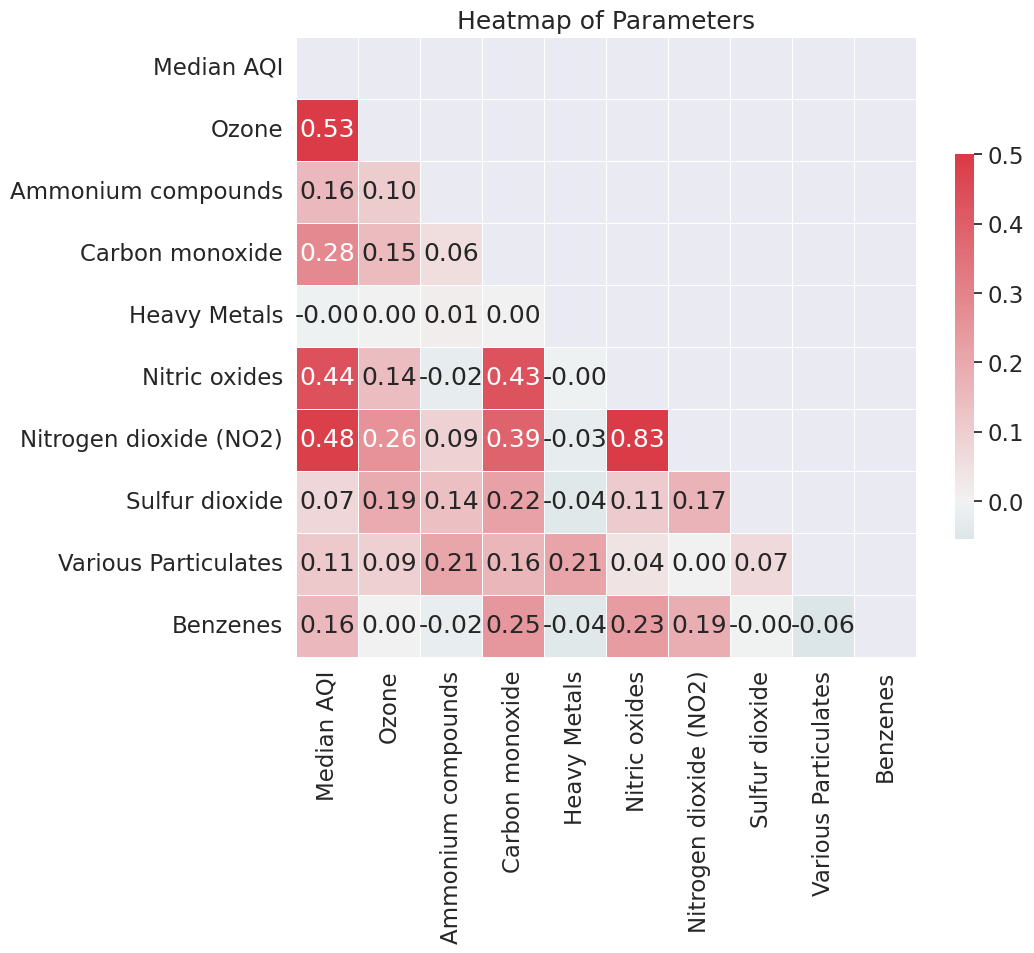

In [10]:
corr = df2[parameters].corr()  # type: ignore

# Generate a mask for the top right so we only generate one correlation per
# pair of factors.
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

# Generate custom color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create figure using seaborn:
heat_fig, heat_ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.5,
    center=0,
    square=True,
    linewidths=0.5,  # type: ignore
    cbar_kws={"shrink": 0.5},
    annot=True,
    fmt=".2f",
    ax=heat_ax,
)
heat_ax.set(title="Heatmap of Parameters")
None

There's not much to say here, other then that this is a simple correlation heatmap to confirm that the correlation between parameters mentioned above were not unrealistic - and overall, the parameters are generally correlated with the same relation as above. However, it is worth it to note that benzenes and heavy metals are the only parameters to have negative relations with other parameters tending to show that they are not a major contributor to air quality.

---

In [11]:
# Export data if data processing has changed
df = df.set_crs(crs)
healthdata = healthdata.set_crs(crs)
df.drop(columns="geometry").to_csv(utils.PROJECT_ROOT / "data/processed/processed1.csv", index=False)
df[["CBSAFP", "geometry"]].drop_duplicates().to_file(  # type: ignore
    utils.PROJECT_ROOT / "data/processed/geodata1.geojson", driver="GeoJSON", **utils.GPD_WRITE_KWARGS
)
healthdata.to_file(utils.PROJECT_ROOT / "data/processed/heath1.geojson", driver="GeoJSON", **utils.GPD_WRITE_KWARGS)  # type: ignore